## 信用卡欺诈检测
基于信用卡交易记录数据，建立分类模型来预测哪些交易记录是异常的，哪些是正常的。

我整理好的数据地址：https://pan.baidu.com/s/18vPGelYCXGqp5OCWZWz36A 提取码：de0f

kaggle数据地址：https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv

kesci数据地址：https://www.kesci.com/mw/dataset/5b56a592fc7e9000103c0442

### 任务目的：
完成数据集中正常交易数据和异常交易数据的分类，并对测试数据进行预测 0/1进行分类。

### 任务流程：
* 加载数据，观测问题
* 针对问题给出解决方案
* 数据集划分
* 评估方法对比
* 逻辑回归模型
* 建模结果分析
* 方案效果对比

### 主要解决问题：
  (1) 在此项目中，我们首先对数据进行观测，发现了其中样本不均衡的问题，其实我们做任务工作之前都一定要先进行数据检查，看看数据有什么问题，针对这些问题来选择解决方案。
  (2) 这里我们提出了两种方法，下采样和过采样，两条路线来进行对比实验，任何时间问题来了之后，我们都不会一条路走到黑，没有对比就没有优化，通常会得到一个基础模型，然后对各种方法进行对比，找到最合适的，然后在任务开始之前，一定得多想多准备，得到的结果才有可选择的余地。
  (3) 在建模之前，需要对数据进行各种预处理操作，比如数据标准化，缺失值填充等，这些都是必要操作，由于数据本身已经给定了特征，此处我们还没有提到特征工程这个概念，后续实战中我们会逐步引入，其实数据预处理的工作是整个任务中最为重要也是最优难度的一个阶段，数据决定上限，模型逼近这个上限。
  (4) 先选好评估方法，再进行建模。建模的目的是为了得到结果，但是我们不可能一次就得到最好的结果，肯定要尝试很多次，所以一定要有一个合适的评估方法，比如通用的AUC、ROC、召回率、精确率等，也可以根据实际问题自己指定评估指标。
  (5) 选择合适的算法，这里我们使用的逻辑回归，逻辑回归现在使用的很少，但在金融领域还是一个非常具有代表的算法，其简单并具有可推导及解释性，深受金融行业的爱戴。
  (6) 模型调参也是非常重要的，不用的调参会导致不同的结果，后续实战中我们也会有更多的调参细节，对于调参可以参考工具包的API文档，了解每个参数的意义，再来选择合适的参数值。
  (7) 得到结果一定是和实际任务结合在一起，有时候线下（开发）时效果不错，但是上线后效果差距很大，所以测试环境也是必不可少的。

In [25]:
# 导入工具包
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 把图轻松的镶嵌到这个notebook中
%matplotlib inline

import warnings  # 忽略普通警告，不打印太多东西
warnings.filterwarnings('ignore')

In [4]:
# 读取数据
data = pd.read_csv("data/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 数据情况说明：
数据集包含由欧洲人于2013年9月使用信用卡进行交易的数据。此数据集显示两天内发生的交易，其中284807笔交易中有492笔被盗刷。数据集非常不平衡，正例（被盗刷）占所有交易的0.172％。，这是因为由于保密问题，我们无法提供有关数据的原始功能和更多背景信息。特征V1，V2，... V28是使用PCA获得的主要组件，没有用PCA转换的唯一特征是“Class”和“Amount”。特征'Time'包含数据集中每个刷卡时间和第一次刷卡时间之间经过的秒数。特征'Class'是响应变量，如果发生被盗刷，则取值1，否则为0。

0    284315
1       492
Name: Class, dtype: int64


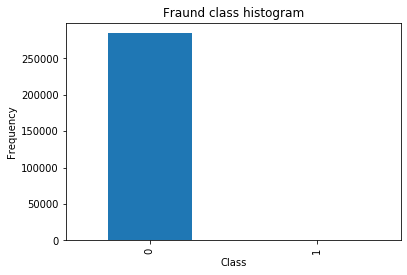

In [5]:
# 数据标签分布
count_classes = pd.value_counts(data['Class'], sort=True).sort_index()  # 统计里面不同分类的量
count_classes.plot(kind='bar')  # 使用直方图
plt.title("Fraund class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
print(count_classes)

明显的正负样本数量有差异，正样本（为1）只有492个，负样本有28万个，这种情况下，如果直接给模型学习，那么模型很容易知道，只要它把样本预测为负，那么准确率就在99.99%以上。

我们不能让模型学到这种歪门技巧。

有两种方案解决：
* 1和0一样多，也就是1也有28万个左右。（上采样）
* 0和1一样少，也就是28万里只取492个。（下采样）

两个方案的比较：
* 第一种需要造一些数据，那么数据就是假的，假的会影响模型在预测真实数据时，结果自然会下降。
* 第二种方式则会减少真实数据，使得模型可学的数据变少，能力也会减弱。

### 数据标准化处理

上面Amount列的值还是原值，相比其它列的值过大，会导致模型结果出现偏差，认为Amount列是非常重要的，具体可参考前面讲过的回归分析章节，需要对其标准化，大的值在区间内依然是大的，小的值在区间内依然是小的，可以理解为一种缩放。

对逻辑回归来说，所有的训练数据都需要进行标准化。

In [6]:
from sklearn.preprocessing import StandardScaler

# X = (x-μ)/σ,使得新的X数据集方差为1，均值为0
# fit_transform(data['Amount']) 意思是找出data['Amount']的μ和σ，并应用在data['Amount']上。
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data = data.drop(['Time', 'Amount'], axis=1)  # Time这里用不上也去掉
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


### 下采样方案

In [7]:
X = data.loc[:,data.columns != "Class"]  # 特征
y = data.loc[:,data.columns == "Class"]  # 标签
 
# 得到正样本（异常样本）的索引
number_records_fraud=len(data[data.Class==1])
fraud_indices=np.array(data[data.Class==1].index)

# 得到负样本（正常样本）的索引
normal_indices=data[data.Class==0].index
 
# 从正常样本中随机采样指定个数的样本，并取索引
random_normal_indices=np.random.choice(normal_indices, number_records_fraud,replace=False) 
random_normal_indices=np.array(random_normal_indices)

# 有了正常样本和异常样本的所以
under_sample_indices=np.concatenate([fraud_indices,random_normal_indices])

# 根据索引得到下采样的所有样本点
under_sample_data=data.iloc[under_sample_indices,:]

X_under_sample=under_sample_data.iloc[:,under_sample_data.columns != "Class"]
Y_under_sample=under_sample_data.iloc[:,under_sample_data.columns == "Class"]

print("正常样本所占整体比例：", len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("异常样本所占整体比例：", len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("下采样策略总体样本量：", len(under_sample_data))

正常样本所占整体比例： 0.5
异常样本所占整体比例： 0.5
下采样策略总体样本量： 984


### 交叉验证

In [12]:
from sklearn.model_selection import train_test_split  # 切分数据集

# 将数据切割成训练集0.7 和测试集 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print("原始训练集包含样本量：", len(X_train))
print("原始测试集包含样本量：", len(X_test))
print("原始样本总数：", len(X_train)+len(X_test))

# 下采样数据集进行划分
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_under_sample
                                                                                                   ,Y_under_sample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
 
print("\n")
print("下采样训练集包含样本数量: ", len(X_train_undersample))
print("下采样测试集包含样本数量: ", len(X_test_undersample))
print("下采样样本总数: ", len(X_train_undersample)+len(X_test_undersample))

原始训练集包含样本量： 199364
原始测试集包含样本量： 85443
原始样本总数： 284807


下采样训练集包含样本数量:  688
下采样测试集包含样本数量:  296
下采样样本总数:  984


### 模型的评估方法——召回率
由于目前正负样本极度不平衡，如果用准确率，那么和上面说的一样，模型把全部评定为正常样本，准确率就达到99.99%。这里用召回率，即异常样本找到多少个。

Recall = TP/(TP+FN)

* TP，即 True Positive =正确地判断成正例
* TN，即 True negative=正确地判断成负例
* FP，即False Positive =错误地判断成正例
* FN ，即False negative =错误地判断成负例

In [14]:
# 在sklearn库的线性模块中，调取“逻辑回归”
from sklearn.linear_model import LogisticRegression  

#交叉验证模块中，选用“K折交叉验证”
#cross_val_score函数返回的是一个使用交叉验证以后的评分标准。
from sklearn.model_selection import KFold, cross_val_score  

# 混淆矩阵、召回率
# sklearn中的classification_report函数用于显示主要分类指标的文本报告，在报告中显示每个类的精确度，召回率，F1值等信息。
from sklearn.metrics import confusion_matrix,recall_score,classification_report 

# cross_val_predict 和 cross_val_score的使用方法是一样的，但是它返回的是一个使用交叉验证以后的输出值，而不是评分标准。
from sklearn.model_selection import cross_val_predict

### 正则化惩罚——提高模型泛化能力
模型过拟合通常出现在，数据量少的同时特征又多，也就是当下的情况，异常样本非常少，特征维度有28个。

In [29]:
# 编写Kflod函数——printing_Kfold_scores，实际中我们可以直接调用
def printing_Kfold_scores(x_train_data,y_train_data):
    fold = KFold(5,shuffle=False)      #shuffle=False是指数据集不用洗牌
 
 # 定义不同力度的正则化惩罚力度，值越大惩罚力度越小
    c_param_range = [0.01,0.1,1,10,100]
 # 展示结果用的表格
    results_table = pd.DataFrame(index = range(len(c_param_range),2), columns = ['C_parameter','Mean recall score'])
    results_table['C_parameter'] = c_param_range
 
 # k-fold 表示K折的交叉验证，这里会得到两个索引集合: 训练集 = indices[0], 验证集 = indices[1]
    j = 0
 # 循环遍历不同的参数（这里的c_param_rang是5个——5折交叉验证）
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('正则化惩罚力度: ', c_param)
        print('-------------------------------------------')
        
        # 计算每一次迭代后的召回率，一次5次
        recall_accs = []
 
         # 一步步分解来执行交叉验证
        for iteration, indices in enumerate(fold.split(x_train_data)):
 
            # 选择算法模型+给定参数
            lr = LogisticRegression(C = c_param, penalty = 'l1')  #L1正则化防止过拟合，通过k折交叉验证寻找最佳的参数C。 

            # 训练模型。注意索引不要给错了，训练的时候一定传入的是训练集，所以X和Y的索引都是0
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())

            # 使用验证集预测模型结果，这里用的就是验证集，索引为1
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)

            # 评估模型。有了预测结果之后就可以来进行评估了，这里recall_score需要传入预测值和真实值。
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,y_pred_undersample)
            # 保存每一步的结果，以便后续计算平均值。
            recall_accs.append(recall_acc)
            print('Iteration ', iteration,': 召回率 = ', recall_acc)

        # 当执行完所有的交叉验证后，计算平均结果
        results_table.loc[j,'Mean recall score'] = np.mean(recall_accs)
        j += 1 # 在这儿的意思是 num = num + 1
        print('')
        print('平均召回率 ', np.mean(recall_accs))
        print('')

    # 找到最好的参数，哪一个Recall高，自然就是最好的了。
    best_c = results_table.loc[results_table['Mean recall score'].astype('float32').idxmax()]['C_parameter']

    # 打印最好的结果
    print('***********************************')
    print('效果最好的模型所选参数 = ', best_c)
    print('***********************************')

    return best_c

交叉验证与不同参数的结果

In [30]:
best_c = printing_Kfold_scores(X_train_undersample,y_train_undersample)

-------------------------------------------
正则化惩罚力度:  0.01
-------------------------------------------
Iteration  0 : 召回率 =  0.9315068493150684
Iteration  1 : 召回率 =  0.9178082191780822
Iteration  2 : 召回率 =  1.0
Iteration  3 : 召回率 =  0.972972972972973
Iteration  4 : 召回率 =  0.9545454545454546

平均召回率  0.9553666992023157

-------------------------------------------
正则化惩罚力度:  0.1
-------------------------------------------
Iteration  0 : 召回率 =  0.8493150684931506
Iteration  1 : 召回率 =  0.863013698630137
Iteration  2 : 召回率 =  0.9491525423728814
Iteration  3 : 召回率 =  0.9324324324324325
Iteration  4 : 召回率 =  0.9090909090909091

平均召回率  0.900600930203902

-------------------------------------------
正则化惩罚力度:  1
-------------------------------------------
Iteration  0 : 召回率 =  0.8493150684931506
Iteration  1 : 召回率 =  0.8904109589041096
Iteration  2 : 召回率 =  0.9830508474576272
Iteration  3 : 召回率 =  0.9459459459459459
Iteration  4 : 召回率 =  0.9090909090909091

平均召回率  0.9155627459783485

--------------

In [31]:
# 混淆矩阵
def plot_confusion_matrix(cm, classes,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
    """
    绘制混淆矩阵
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

召回率:  0.9319727891156463


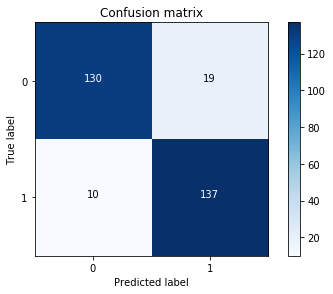

In [32]:
import itertools
# 选择最优正则化参数
lr = LogisticRegression(C = best_c, penalty = 'l1')
# 训练模型
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
# 测试模型
y_pred_undersample = lr.predict(X_test_undersample.values)
# 计算所需值
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)
np.set_printoptions(precision=2)
 
print("召回率: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
# 绘制
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

右上角19表示原本正常的，被判定为异常。右下角表示原本异常的，被判定为异常的。看似结果不错。

但这里还不是我们的原始需求，我们的原始需求是在28万多个中，找到492个异常的。而目前是1：1的比例。

召回率:  0.9183673469387755


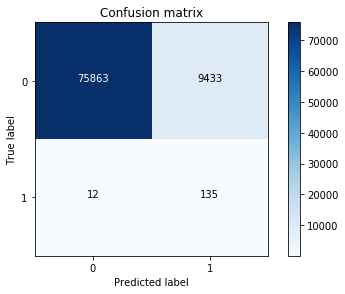

In [33]:
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
# 代码和上面大致相同，唯一不同的，是这里我们使用的是真实比例
y_pred = lr.predict(X_test.values)
 
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)
 
print("召回率: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
 
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

第一眼看到召回率92.8%貌似不错，但是右上角9433，表示有这么多正常的人被预测为异常，误判了这么多人。